0
(array(['000000_10.png'], dtype=object), array([0], dtype=int32))
(388, 1240, 3)
current batch


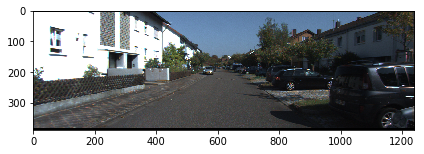

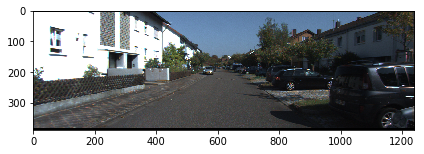

1
(array(['000001_10.png'], dtype=object), array([0], dtype=int32))
(388, 1240, 3)
current batch


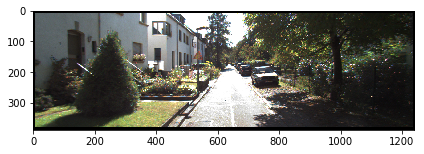

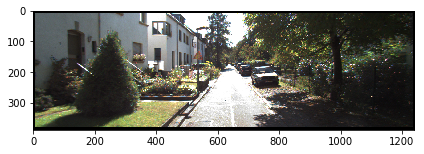

2
(array(['000002_10.png'], dtype=object), array([0], dtype=int32))
(388, 1240, 3)
current batch


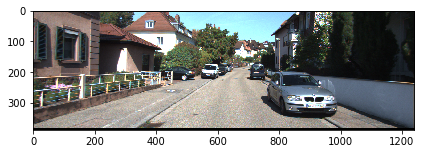

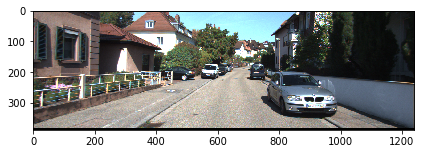

3
(array(['000003_10.png'], dtype=object), array([0], dtype=int32))
(388, 1240, 3)
current batch


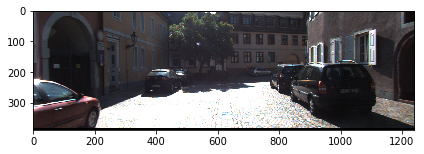

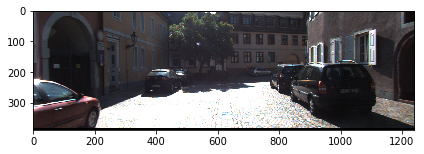

4
(array(['000004_10.png'], dtype=object), array([0], dtype=int32))
(388, 1240, 3)
current batch


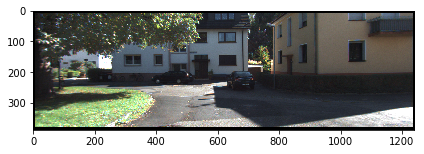

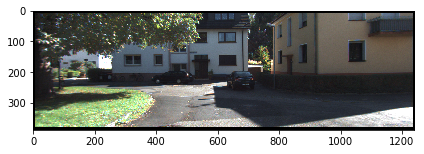

5
(array(['000005_10.png'], dtype=object), array([0], dtype=int32))
(388, 1240, 3)
current batch


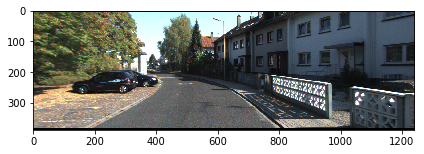

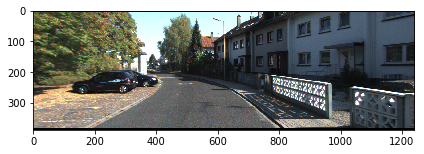

6
(array(['000006_10.png'], dtype=object), array([0], dtype=int32))
(388, 1240, 3)
current batch


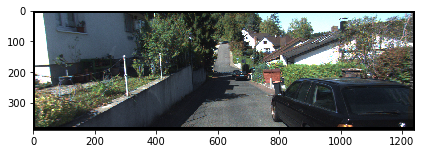

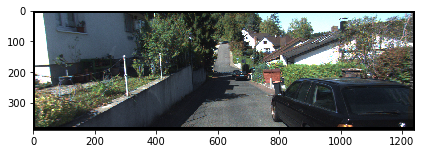

7
(array(['000007_10.png'], dtype=object), array([0], dtype=int32))
(388, 1240, 3)
current batch


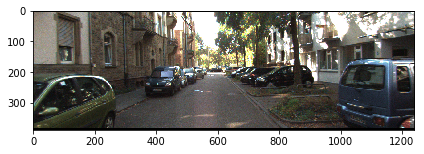

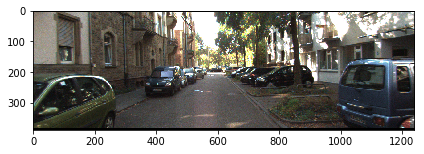

In [6]:
import tensorflow as tf
import skimage.io as io
import numpy as np

IMAGE_HEIGHT = 388
IMAGE_WIDTH = 1240
DEPTH = 3

tfrecords_filename = '/home/laoreja/dataset/tfrecords_KITTI_half/test-00000-of-00008'

def read_and_decode(filename_queue):
    
    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'left_image_raw':tf.FixedLenFeature([], tf.string),
        'right_image_raw':tf.FixedLenFeature([], tf.string),
#         'mask_raw': tf.FixedLenFeature([], tf.string),
#         'disparity_raw': tf.FixedLenFeature([], tf.string),
        'filename': tf.FixedLenFeature([], tf.string),
        'subset_idx':tf.FixedLenFeature([], tf.int64)
        })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    left_image = tf.decode_raw(features['left_image_raw'], tf.uint8)
    right_image = tf.decode_raw(features['right_image_raw'], tf.uint8)
#     mask = tf.decode_raw(features['mask_raw'], tf.uint8)
#     disparity = tf.decode_raw(features['disparity_raw'], tf.float32)
        
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    subset_idx = tf.cast(features['subset_idx'], tf.int32)
    
    tf.Print(features['subset_idx'], [features['subset_idx']])
    tf.Print(features['filename'], [features['filename']])
        
    image_shape = tf.stack([height, width, DEPTH])
    disparity_shape = tf.stack([height, width, 1])
    
    left_image = tf.reshape(left_image, image_shape)
    right_image = tf.reshape(right_image, image_shape)    
#     disparity = tf.reshape(disparity, disparity_shape)
#     mask = tf.reshape(mask, disparity_shape)
    
    left_image = tf.image.resize_image_with_crop_or_pad(image=left_image,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    right_image = tf.image.resize_image_with_crop_or_pad(image=right_image,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
#     disparity = tf.image.resize_image_with_crop_or_pad(image=disparity,
#                                            target_height=IMAGE_HEIGHT,
#                                            target_width=IMAGE_WIDTH)
#     mask = tf.image.resize_image_with_crop_or_pad(image=mask,
#                                            target_height=IMAGE_HEIGHT,
#                                            target_width=IMAGE_WIDTH)

    #mask, [IMAGE_HEIGHT, IMAGE_WIDTH, 1]
#     left_images, right_images, disparities, masks = tf.train.shuffle_batch( [left_image, right_image, disparity, mask],
#                                                  batch_size=1,
#                                                  capacity=30,
#                                                  num_threads=2,
#                                                  min_after_dequeue=10,
#                                                  shapes=[[IMAGE_HEIGHT, IMAGE_WIDTH, DEPTH], 
#                                                          [IMAGE_HEIGHT, IMAGE_WIDTH, DEPTH], 
#                                                          [IMAGE_HEIGHT, IMAGE_WIDTH, 1],
#                                                          [IMAGE_HEIGHT, IMAGE_WIDTH, 1]])

    left_images, right_images, filenames, subset_idxs = tf.train.batch( [left_image, right_image, features['filename'], subset_idx],
                                                 batch_size=1,
                                                 capacity=30,
                                                 num_threads=1,
                                                 shapes=[[IMAGE_HEIGHT, IMAGE_WIDTH, DEPTH], 
                                                         [IMAGE_HEIGHT, IMAGE_WIDTH, DEPTH], 
#                                                          [IMAGE_HEIGHT, IMAGE_WIDTH, 1],
#                                                          [IMAGE_HEIGHT, IMAGE_WIDTH, 1],
                                                         [],
                                                         []])

    
    return left_images, right_images, filenames, subset_idxs,


filename_queue = tf.train.string_input_producer(
    [tfrecords_filename], shuffle=False)

# Even when reading in multiple threads, share the filename
# queue.
lim, rim, f, idx = read_and_decode(filename_queue) #m

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())


with tf.Session()  as sess:
    
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Let's read off 3 batches just for example
    for i in xrange(8):
        print i
        _lim, _rim, _f, _idx = sess.run([lim, rim, f, idx]) #m, _m
        print(_f, _idx)
        print(_lim[0, :, :, :].shape)
#         print(_d.shape)
        
        print('current batch')
        
        # We selected the batch size of two
        # So we should get two image pairs in each batch
        # Let's make sure it is random

        io.imshow(_lim[0, :, :, :])
        io.show()

        io.imshow(_rim[0, :, :, :])
        io.show()
        
#         io.imshow(_d[0, :, :, 0])
#         io.show()
        
#         _d[np.where(np.logical_not(_m))] = 0
#         print np.sum(_m)
#         io.imshow(_d[0, :, :, 0])
#         io.show()
        
        
#         print(_d[0, :10, :10, 0])
        
#         io.imshow(_lim[1, :, :, :])
#         io.show()
        
#         io.imshow(_rim[1, :, :, :])
#         io.show()        

#         io.imshow(_d[1, :, :, 0])
#         io.show()
        
    
    coord.request_stop()
    coord.join(threads)